
<table><tr>
    <td><img src="imagenes/Macc.png"/></td>
    <td><p style="font-size:18pt">Semillero de Modelación y Simulación de Fenómenos Sociales</p></td>
</tr></table>

<p align="right" style="font-size:10pt">Versión 2021-1</p>

# Simulación del Modelo del bar El Farol

## Descripción del juego iterativo

En el presente modelo se tiene una población de $N$ individuos, quienes deben tomar la decisión de si acudirán o no al bar llamado "El Farol". Cada agente toma esta decisión de manera independiente a los demás, y todos lo hacen de manera simultánea. 

<table><tr>
    <td><img src="imagenes/ElFarol1.jpeg"/></td>
    <td><img src="imagenes/ElFarol2.jpeg"/></td>
</tr></table>

Si el total de acudientes supera un umbral $\mu$, entonces El Farol se congestionará y los individuos que hayan ido no tendrán una buena experiencia (recompensa=-1). Por otro lado, si el total de los acudientes no supera este umbral, quienes hayan asistido podrán disfrutar de su estadía en el bar (recompensa=1). Adicionalmente, si un individuo no asiste al bar, será indiferente al estado de El Farol (recompensa=0). Cada agente intentará tomar la mejor decisión posible con respecto a asistir o no al bar. Esta situación se repetirá por un número $k$ de iteraciones. 

## Implementación en Python

#### AGENTES 

Los agentes que se simularán tendrán 2 atributos:

`estado`: Es la estrategia tomada por el agente y que puede ser ir al bar (1) o abstenerse de ir (0).

`puntaje`: Puntaje obtenido. Hay tres posibilidades:

- **1** Si fue y la proporción de agentes que fueron fue menor que el $\mu $ determinado ($\mu=0.5$).
- **0**, si decidió no ir.
- **-1**, si fue y la proporción de agentes que fueron fue mayor que el $\mu$ determinado ($\mu=0.5$).

La impementación en Python de estos atributos tiene la característica siguiente. Cada atributo se almacena como una lista, la cual guarda la información correspondiente por cada ronda. Esto es, por ejemplo, `agente.estado[0]` es el estado del agente en la primera ronda.

Los agentes tendrán 2 métodos:

`toma_decision`(`modelo`, `parametros`): Es el método que le dice al agente qué estrategia seguir, la cual se decidirá de acuerdo al `modelo` seleccionado con los `parametros` dados.

`imprime_agente(r)`: imprime los datos del agente en la ronda `r`.

In [3]:
import pandas as pd
import seaborn as sns
from random import uniform
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.optimize import minimize, Bounds
from itertools import product

In [4]:
def softmax(opciones, beta=0) :
    opciones_softmax = [np.exp(beta*opcion) for opcion in opciones]
    suma = np.sum(opciones_softmax)
    return np.multiply(opciones_softmax, [1/suma]*len(opciones))

class Agente :
    
    def __init__(self, estados, puntajes, atractivos) :
        self.estado = estados # lista
        self.puntaje = puntajes # lista
        self.atractivo = atractivos # lista
        
    def toma_decision(self, modelo='aleatorio', parametros=[0,0.5], DEB=False) :
        '''
        Se lanza un "dado" para decidir aleatoriamente si el agente va o no al bar
        de acuerdo a si supera el umbral dado por el valor de para_ir
        '''
        atractivo=self.atractivo[-1] # Valor por defecto
        beta=0

        # determina el valor de para_ir de acuerdo al modelo y sus parámetros
        if modelo == 'aleatorio' :
            beta=parametros[0]
            atractivo=parametros[1]
        
        if modelo == 'rescorla-wagner' :
            beta=parametros[0]
            recompensa=(self.puntaje[-1]+1)/2
            alfa=parametros[1]
            q0=parametros[2]
            atractivo=self.atractivo[-1]+alfa*(recompensa-self.atractivo[-1])

        if modelo == 'win-stay-lose-shift' :
            beta=parametros[0]
            epsilon = parametros[1]
            gamma = parametros[2]
            if self.puntaje[-1] >= gamma :
#                atractivo = 1 - epsilon/2
                atractivo = max(self.atractivo[-1] - epsilon/2, 0)
            else:
#                atractivo = epsilon/2
                atractivo = max((1 - self.atractivo[-1]) - epsilon/2, 0)

        # Softmax de atractivo
        if DEB :
            print("Softmax:", softmax([atractivo,1-atractivo], beta))
        atractivo = softmax([atractivo,1-atractivo], beta)[0]
        atractivo = round(atractivo, 2)
        if DEB :
            print(f"atractivo anterior:{self.atractivo[-1]}; atractivo nuevo:{atractivo}")

        # Actualiza el atractivo del agente
        self.atractivo.append(atractivo)

        
        # Lanza el dado
        if uniform(0,1) < atractivo :
            self.estado.append(1)
        else :
            self.estado.append(0)

    def imprime_agente(self, ronda) :
        try:
            estado = self.estado[ronda]
        except:
            estado = "nan"
        try:
            puntaje = self.puntaje[ronda]
        except:
            puntaje = "nan"
        try:
            atractivo = self.atractivo[ronda]
        except:
            atractivo = "nan"

        return "Estado:{0}, Puntaje:{1}, Atractivo:{2}".format(estado, puntaje, atractivo)
            

#### BAR

El bar será un objeto con los siguientes atributos:

`num_agentes`: cantidad de agentes que pueden ir al bar.

`agentes`: agentes que pueden ir al bar.

`umbral`: proporción de `agentes` que puede ir al bar para que la velada sea agradable.

`num_iteraciones`: cantidad de rondas.

`historia`: lista de la asistencia en todas las rondas pasadas.

El bar tendrá los siguientes métodos:

`calcular_asistencia()`: determina la cantidad de `agentes` que tomaron la decisión de ir al bar y actualiza la `historia`.

`calcular_puntajes()`: determina los puntajes de los `agentes` de acuerdo a la asistencia y a las decisiones respectivas. 

`agentes_deciden()`: solicita a los agentes que tomen una decisión.

`imprime_ronda(r)`: imprime la ronda `r`-ésima.

In [5]:
from random import randint 
import numpy as np

class BarElFarol :
    
    def __init__(self, num_agentes, umbral, num_iteraciones, modelo='aleatorio', parametros=[.5]) :
        self.num_agentes = num_agentes
        self.umbral = umbral
        self.num_iteraciones = num_iteraciones
        self.historia = []
        self.agentes = []
        for i in range(self.num_agentes) :
            if modelo == 'aleatorio' :
                self.agentes.append(Agente([randint(0,1)], [], [parametros[0]]))        
            if modelo == 'rescorla-wagner' :
                self.agentes.append(Agente([randint(0,1)], [], [parametros[1]]))        
            if modelo == 'win-stay-lose-shift' :
#                self.agentes.append(Agente([randint(0,1)], [], uniform(0,1))) 
                aleatorio = randint(0,1)
                self.agentes.append(Agente([aleatorio], [], [aleatorio])) 
            
    def calcular_asistencia(self) :
        asistencia = np.sum([a.estado[-1] for a in self.agentes])
        self.historia.append(asistencia)

    def calcular_puntajes(self) :
        asistencia = self.historia[-1]/self.num_agentes
        for a in self.agentes:
            if a.estado[-1] == 1:
                if asistencia > self.umbral:
                    a.puntaje.append(-1)
                else:
                    a.puntaje.append(1)
            else:
                a.puntaje.append(0)

    def agentes_deciden(self, modelo='aleatorio', parametros=[0.5], DEB=False) :
        for a in self.agentes :
            a.toma_decision(modelo, parametros, DEB=DEB)
                
    def imprime_ronda(self, ronda) :
        try:
            asistencia = self.historia[ronda]
        except:
            asistencia = "nan"
        cadena = '='*30
        cadena += f"\nRonda: {ronda} || Asistencia: {asistencia}"
        for a in self.agentes:
            cadena += "\n" + a.imprime_agente(ronda)
        print(cadena)
        
    def guardar_pandas(self) :
        dict = {}
        ronda = []
        agentes = []
        estados = []
        puntajes = []
        atractivos = []
        for i in range(len(self.agentes)):
            a = self.agentes[i]
            ronda += [x for x in range(1, len(a.estado))]
            agentes += [i]*len(a.puntaje)
            estados += a.estado[:-1]
            puntajes += a.puntaje
            atractivos += a.atractivo[:-1]
#        print(len(agentes), len(estados), len(puntajes), len(atractivos))
        dict['round'] = ronda
        dict['player'] = agentes
        dict['choice'] = estados
        dict['score'] = puntajes
        dict['motivated'] = atractivos
        return pd.DataFrame.from_dict(dict)

Con las funciones anteriores estamos listos para hacer la simulación, definiendo los parámetros iniciales:

In [6]:
num_agentes=5
umbral=0.6
num_iteraciones=5
# modelo='aleatorio'
# p = 0.5
# beta = 2
# parametros = [beta,p]
modelo='rescorla-wagner'
beta=1
alfa=0.1
q0=0.7
parametros=[beta,alfa,q0]
#modelo='win-stay-lose-shift'
#beta=100
#epsilon=0
#gamma=1
#parametros=[beta,epsilon,gamma]

bar=BarElFarol(
    num_agentes, 
    umbral, 
    num_iteraciones, 
    modelo=modelo, 
    parametros=parametros
)
# bar.imprime_ronda(0)

In [7]:
DEB=False
for t in range(num_iteraciones) : 
    bar.calcular_asistencia()
    bar.calcular_puntajes()
    if DEB :
        bar.imprime_ronda(t)
    bar.agentes_deciden(modelo=modelo, parametros=parametros, DEB=DEB)


<AxesSubplot:>

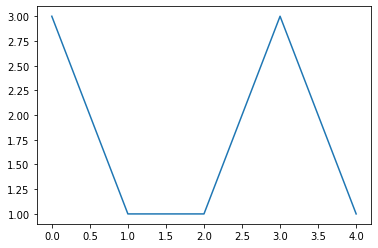

In [8]:
data = pd.DataFrame({'asistencia': bar.historia})
data['asistencia'].plot()

---

In [9]:
def simulacion(modelo,parametros,num_agentes,umbral,num_iteraciones,Nsim=1) :
    lista_dataframes = []
    for n in range(Nsim):
        bar=BarElFarol(
            num_agentes, 
            umbral, 
            num_iteraciones, 
            modelo=modelo, 
            parametros=parametros
        )        
        for t in range(num_iteraciones) : 
            bar.calcular_asistencia()
            bar.calcular_puntajes()
            bar.agentes_deciden(modelo=modelo,parametros=parametros,DEB=False)
        data = bar.guardar_pandas()
        data.sort_values(by=['round', 'player'], inplace=True)
        data['group'] = n
        data=data[['group','round','player','choice','score','motivated']]
        lista_dataframes.append(data)
    return pd.concat(lista_dataframes)

def visual(data_sim, data_obs) :
    data = pd.concat([data_sim,data_obs])
    attendance = pd.DataFrame(data.groupby(['source', 'group', 'round'])['choice'].sum().reset_index())
    attendance.columns = ['source', 'group', 'round', 'attendance']
    scores = pd.DataFrame(data.groupby(['source','group','player'])['score'].mean().reset_index())
    fig,ax=plt.subplots(1,2,figsize=(8,4))
    sns.lineplot('round', 'attendance', hue='source', data=attendance,ax=ax[0])
    sns.boxplot(data=scores, y='score', x='source', ax=ax[1])
    ax[0].set_title("Average attendance per round")
    ax[1].set_title("Distribution of average score")

In [12]:
modelo='rescorla-wagner'
beta=4
alfa=0.01
q0=0.7
parametros=[beta,alfa,q0]
num_agentes=5
umbral=0.6
num_iteraciones=50
data_sim = simulacion(modelo,parametros,num_agentes,umbral,num_iteraciones,Nsim=100)
data_sim.head()

,group,round,player,choice,score,motivated
0,0,1,0,0,0,0.01
50,0,1,1,0,0,0.01
100,0,1,2,0,0,0.01
150,0,1,3,1,1,0.01
200,0,1,4,1,1,0.01


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


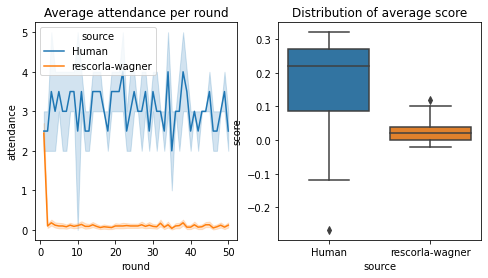

In [13]:
data_sim['source'] = modelo
data_obs = pd.read_csv('observed.csv')
data_obs['source'] = 'Human'
visual(data_sim,data_obs)

In [14]:
def obtener_frecuencias(data_sim) :  
    data_sim['score_lag'] = data_sim.groupby(['group', 'player'])['score'].shift(1)
    data_sim['motivated_lead'] = data_sim.groupby(['group', 'player'])['motivated'].shift(-1)
    data_sim['choice_lead'] = data_sim.groupby(['group', 'player'])['choice'].shift(-1)
    df = pd.DataFrame(data_sim.groupby(['score', 'motivated']).
                      agg(attended=pd.NamedAgg(column="choice_lead", aggfunc="sum"),
                          total=pd.NamedAgg(column="choice_lead", aggfunc="count"),
#                          predicted=pd.NamedAgg(column="motivated_lead", aggfunc="mean")
                         ).
                      reset_index())
    df['freq_attended'] = df['attended']/df['total']
#    del df['attended']
#    del df['total']
    return df

def predecir_motivacion(modelo, parametros, puntaje, atractivo_anterior) :
    # determina el valor de para_ir de acuerdo al modelo y sus parámetros
    if modelo == 'aleatorio' :
        beta=parametros[0]
        atractivo=parametros[1]
        
    if modelo == 'rescorla-wagner' :
        beta=parametros[0]
        recompensa=(puntaje+1)/2
        alfa=parametros[1]
        q0=parametros[2]
        atractivo=atractivo_anterior+alfa*(recompensa-atractivo_anterior)

    if modelo == 'win-stay-lose-shift' :
        beta=parametros[0]
        epsilon = parametros[1]
        gamma = parametros[2]
        if puntaje >= gamma :
            atractivo = max(atractivo_anterior - epsilon/2, 0)
        else:
            atractivo = max((1 - atractivo_anterior) - epsilon/2, 0)

    # Softmax de atractivo
    atractivo = softmax([atractivo,1-atractivo], beta)[0]
    atractivo = round(atractivo, 2)
    return atractivo
    
def predecir(data,modelo,parametros) :
#    print("predecir")
#    print(data.head())
    data['predicted'] = data.apply(
        lambda x: predecir_motivacion(
            modelo, 
            parametros,
            x['score'],
            x['motivated']
        ), axis=1)
    return data

def likelihood(data,modelo,parametros) :
    data=predecir(data,modelo,parametros)
    data['likelihood'] = data.apply(
        lambda x: binom.pmf(
            k=x['attended'],
            n=x['total'],
            p=x['predicted']
        ), axis=1)
    return data

def deviance(parametros,data,modelo) :
    data=likelihood(data,modelo,parametros)
    return data['likelihood'].apply(lambda x: -2*np.log(x)).sum()
    
def optimizar(parametros,minimos,maximos,data,modelo):
    x0 = np.array(parametros)
    bounds = Bounds(minimos,maximos)
#    print("Finding fitting parameters. Please wait...")
    res = minimize(
        deviance,
        x0,
        args=(data,modelo),
        method='trust-constr',
#        method='Nelder-Mead',
#        method='Newton-CG',
        bounds=bounds,
        options={'verbose':0}
    )
    return res

def best_fit(minimos,maximos,df,modelo,N=10) :
    best_pars=[np.nan]*len(minimos)
    best_fit=10000
    for k in range(N) :
        randomp=[uniform(minimos[i],maximos[i]) for i in range(len(minimos))]
        res=optimizar(randomp,minimos,maximos,df,modelo)
        pars=[round(x,2) for x in res.x]
        dev=res.fun
        if dev < best_fit :
            best_fit=dev
            best_pars=pars
    return best_pars, best_fit

def model_recovery(modelo,vector_parametros) :
    # Game parameters
    num_agentes=5
    umbral=0.6
    num_iteraciones=50
    lista_parametros=list(product(*vector_parametros))
    parametros_recuperados=[]
    asistencias=[]
    puntajes_promedio=[]
    for parametros in lista_parametros:
        # Simulando
        data_sim=simulacion(modelo,parametros,num_agentes,umbral,num_iteraciones,Nsim=100)
        # Datos relevantes
        asistencias.append(data_sim.groupby(['group','round'])['choice'].sum().mean())
        puntajes_promedio.append(data_sim['score'].mean())
        # Parameter fit
        df=obtener_frecuencias(data_sim)
        minimos=[0,0,-1]
        maximos=[5,.5,1]
        pars,dev=best_fit(minimos,maximos,df,modelo,N=10)
        parametros_recuperados.append(pars)
    return lista_parametros, parametros_recuperados, asistencias, puntajes_promedio

### Ejercicio de recuperación de modelo

Primero simulamos el modelo con unos parámetros dados:

In [15]:
# Game parameters
num_agentes=5
umbral=0.6
num_iteraciones=50

# Simulate data
modelo='rescorla-wagner'
beta=4
alfa=0.01
q0=0.7
parametros=[beta,alfa,q0]
data_sim = simulacion(modelo,parametros,num_agentes,umbral,num_iteraciones,Nsim=100)
#print(data_sim.head())

In [16]:
df = obtener_frecuencias(data_sim)
df.head()

,score,motivated,attended,total,freq_attended
0,-1,0.01,1.0,66,0.015152
1,0,0.01,5.0,243,0.020576
2,0,0.02,452.0,23539,0.019202
3,1,0.01,2.0,191,0.010471
4,1,0.02,8.0,461,0.017354


In [17]:
df=likelihood(df,modelo,parametros)
df.head()

,score,motivated,attended,total,freq_attended,predicted,likelihood
0,-1,0.01,1.0,66,0.015152,0.02,0.355033
1,0,0.01,5.0,243,0.020576,0.02,0.176939
2,0,0.02,452.0,23539,0.019202,0.02,0.012861
3,1,0.01,2.0,191,0.010471,0.02,0.159421
4,1,0.02,8.0,461,0.017354,0.02,0.129186


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

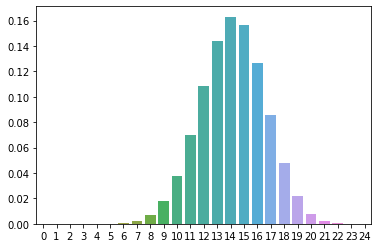

In [18]:
n=24
probs=[]
ks=[]
for k in range(n+1):
    ks.append(k)
    probs.append(binom.pmf(k=k,n=n,p=0.59))
#    print(f"k:{k}, prob:{probs[-1]}")
    
sns.barplot(ks,probs)

Ahora recuperamos los parámetros usando una función de verosimilitud:

In [19]:
deviance(parametros,df,modelo)

22.007552248271026

/usr/local/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Parámetros originales:[4, 0.01, 0.7]
Parámetros recuperados:[3.94, 0.09, 0.67]
Dev: 142.49039739389443


(-1.0, 5.0)

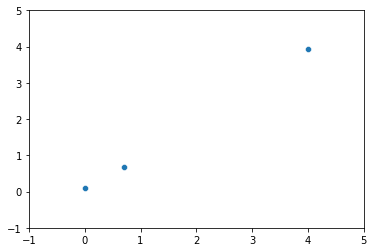

In [20]:
minimos = [0,0,-1]
maximos = [5,.5,1]
randomp = [uniform(minimos[i],maximos[i]) for i in range(len(minimos))]
res = optimizar(parametros,minimos,maximos,df,modelo)
#res = optimizar(randomp,minimos,maximos,df,modelo)
pars = [round(x,2) for x in res.x]

# Results
print(f"Parámetros originales:{parametros}")
print(f"Parámetros recuperados:{pars}")
print(f"Dev: {res.fun}")

fig,ax=plt.subplots()
sns.scatterplot(x=parametros, y=pars, ax=ax)
ax.set_xlim([-1,5])
ax.set_ylim([-1,5])


/usr/local/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py:152: RuntimeWarning: invalid value encountered in double_scalars
  actual_reduction = merit_function - merit_function_next
/usr/local/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Parámetros originales:[4, 0.01, 0.7]
Parámetros recuperados:[4.15, 0.04, -0.57]
Min dev: 22.007552248271026


(-1.0, 5.0)

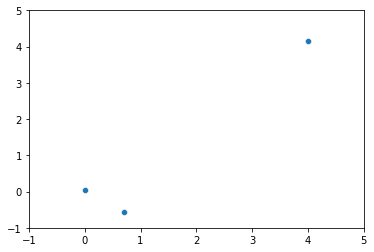

In [21]:
minimos = [0,0,-1]
maximos = [5,.5,1]

df = obtener_frecuencias(data_sim)
pars, dev = best_fit(minimos,maximos,df,modelo,N=100)

# Results
print(f"Parámetros originales:{parametros}")
print(f"Parámetros recuperados:{pars}")
print(f"Min dev: {dev}")

fig,ax=plt.subplots()
sns.scatterplot(x=parametros, y=pars, ax=ax)
ax.set_xlim([-1,5])
ax.set_ylim([-1,5])

In [33]:
# Model recovery exercise
modelo='rescorla-wagner'
betas=[0,2,4,6]
alphas=[0.01,0.05,0.1,0.15]
q0s=[0,0.2,0.4,0.6]
vector_parametros=[betas,alphas,q0s]
lista_parametros,parametros_recuperados,asistencias,puntajes_promedio=model_recovery(modelo,vector_parametros)



/usr/local/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/usr/local/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py:152: RuntimeWarning: invalid value encountered in double_scalars
  actual_reduction = merit_function - merit_function_next


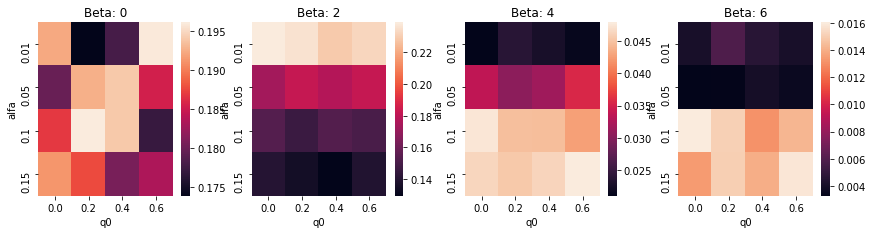

In [34]:
u=sorted(list(set([p[0] for p in lista_parametros])))
z=puntajes_promedio
df=pd.DataFrame(columns=['beta','alfa','q0','av_score'])
for i,pars in enumerate(lista_parametros):
    df.loc[i]=[pars[0],pars[1],pars[2],z[i]]
fig,axes=plt.subplots(1,len(u),figsize=(12,3))
plt.tight_layout()
for ax,i in zip(axes.flatten(), u):
    df1=df[df['beta']==i].pivot('alfa','q0','av_score')
    sns.heatmap(df1,ax=ax)
    ax.set_title("Beta: " + str(i))

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


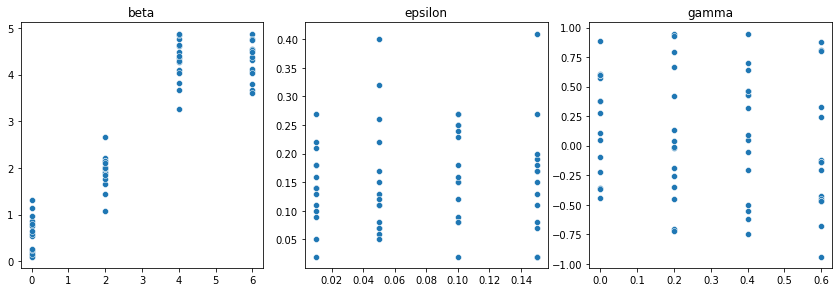

In [35]:
variables=['beta','epsilon','gamma']
fig,axes=plt.subplots(1,3,figsize=(12,4))
plt.tight_layout()
for ax,var in zip(axes.flatten(), range(len(variables))):
    recovery=[(lista_parametros[i][var], parametros_recuperados[i][var]) for i in range(len(lista_parametros))]
    x=[r[0] for r in recovery]
    y=[r[1] for r in recovery]
    sns.scatterplot(x,y,ax=ax)
    ax.set_title(variables[var])

---

Tratando de mejorar el recovery:

* Fijar beta en 4 y ajustar fronteras
* Aumentar la cantidad de iteraciones de la optimización a 100

In [36]:
def model_recovery(modelo,vector_parametros) :
    # Game parameters
    num_agentes=5
    umbral=0.6
    num_iteraciones=50
    lista_parametros=list(product(*vector_parametros))
    parametros_recuperados=[]
    asistencias=[]
    puntajes_promedio=[]
    for parametros in lista_parametros:
        # Simulando
        data_sim=simulacion(modelo,parametros,num_agentes,umbral,num_iteraciones,Nsim=100)
        # Datos relevantes
        asistencias.append(data_sim.groupby(['group','round'])['choice'].sum().mean())
        puntajes_promedio.append(data_sim['score'].mean())
        # Parameter fit
        df=obtener_frecuencias(data_sim)
        minimos=[3.9,0,-1.2]
        maximos=[4.1,.2,1]
        pars,dev=best_fit(minimos,maximos,df,modelo,N=100)
        parametros_recuperados.append(pars)
    return lista_parametros, parametros_recuperados, asistencias, puntajes_promedio

In [37]:
# Model recovery exercise
modelo='rescorla-wagner'
betas=[4]
alphas=[0.01,0.05,0.1,0.15]
q0s=[0,0.2,0.4,0.6]
vector_parametros=[betas,alphas,q0s]
lista_parametros,parametros_recuperados,asistencias,puntajes_promedio=model_recovery(modelo,vector_parametros)



/usr/local/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


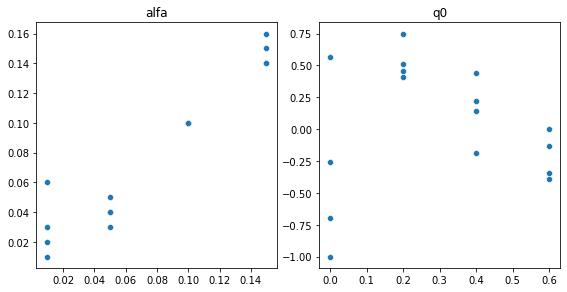

In [39]:
variables=['alfa','q0']
fig,axes=plt.subplots(1,2,figsize=(8,4))
plt.tight_layout()
for ax,k in zip(axes.flatten(), range(len(variables))):
    var=k+1
    recovery=[(lista_parametros[i][var], parametros_recuperados[i][var]) for i in range(len(lista_parametros))]
    x=[r[0] for r in recovery]
    y=[r[1] for r in recovery]
    sns.scatterplot(x,y,ax=ax)
    ax.set_title(variables[var-1])